In [174]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule

In [5]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


In [7]:
def plot_losses(history):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_accuracies(history):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
def plot_lr(history):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    plt.show()

model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 74.98it/s]
epoch 1/50 
 	 -- train loss = 2.606658945539659, train accuracy = 0.3417 
	 -- val loss = 2.6681031740634893, val accuracy = 0.3172 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 78.85it/s]
epoch 2/50 
 	 -- train loss = 2.359775230345653, train accuracy = 0.411 
	 -- val loss = 2.4748258361099564, val accuracy = 0.365 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 74.61it/s]
epoch 3/50 
 	 -- train loss = 2.143277777061135, train accuracy = 0.4602 
	 -- val loss = 2.3052493454702057, val accuracy = 0.3991 


starting epoch: 4 ...
b

batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 85.91it/s]
epoch 36/50 
 	 -- train loss = 1.4126178322882967, train accuracy = 0.6228 
	 -- val loss = 1.8831846868047704, val accuracy = 0.444 


starting epoch: 37 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 79.80it/s]
epoch 37/50 
 	 -- train loss = 1.4542017473012678, train accuracy = 0.6016 
	 -- val loss = 1.910291058476556, val accuracy = 0.4358 


starting epoch: 38 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 79.18it/s]
epoch 38/50 
 	 -- train loss = 1.5278395374799125, train accuracy = 0.5725 
	 -- val loss = 1.9577431563622334, val accuracy = 0.4271 


starting epoch: 39 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 81.27it/s]
epoch 39/50 
 	 -- train loss = 1.5360878884466156, train accuracy = 0.5638 
	 -- val loss = 1.939090905927235, val accuracy = 0.4189 


starting epoch: 40 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 76.33it/s]
epoch 40/50 
 	 -- train loss = 1.

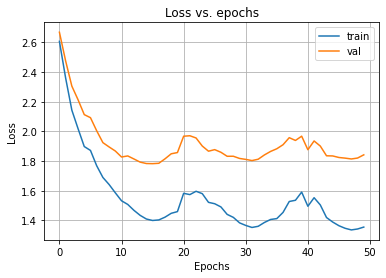

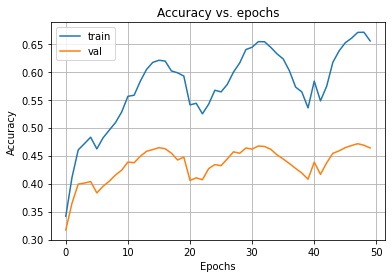

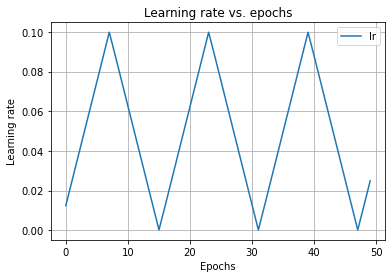

In [13]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 50
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)
plot_lr(history)

In [86]:
l_min = -5
l_max = -1
seed = None#100
np.random.seed(seed)
l = l_min + (l_max - l_min) * np.random.uniform(low=0, high=1)
print(10**l)

0.003235781502499629


In [186]:
class Tuner():
    def __init__(self, build_model, objective, iterations=1, **params):
        # objective is of Metrics for now
        self.build_model = build_model
        self.objective = objective
        self.iterations = iterations
        self.params = params
        self.params_product = list(product(*params.values()))
        self.params_names = list(params.keys())
    
    def search(self, x_train, y_train, x_val, y_val, n_epochs, batch_size):
        # list of tuples = list(product([1,2,3],[3,4]))
        # for tuple in list:
        # rows in final df
        rows = []
        
        #params_product = tqdm(self.params_product, file=sys.stdout)
        
        for prod in self.params_product:
            params = {}
            for idx, param_name in enumerate(self.params_names):
                params[param_name] = prod[idx]
            #print(params)
            
            # if more than 1 iterations
            objective_list = []
            
            for it in range(self.iterations):
                # build_model with tuple params
                model = build_model(seed=200, **params)
                # fit model
                history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
                # meaasure objective on model
                scores_val = model.forward(x_val)
                y_hat_val = np.argmax(scores_val, axis=1)
                objective_val = self.objective.get_metrics(y_val, y_hat_val)
                # save objective in list
                objective_list.append(objective_val)
                
            # average objective in list
            objective_mean = np.array(objective_list).mean()
            # save tuple of params and objective as dict
            objective_dict = {self.objective.name: objective_mean}
            row_dict = {**params, **objective_dict}
            rows.append(row_dict)
        
        # df from list of dicts of params and objective val
        df = pd.DataFrame(data=rows)
        
        # save to csv
        date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
        path = os.path.join("tuner_results", date_string + ".csv")
        
        df.to_csv(path, encoding='utf-8', index=False)
        
        # argmax across rows and return best params as dict (~**params)
        best_params = dict(df.loc[df[self.objective.name].idxmax()])
        best_objective = best_params.pop(self.objective.name)
        
        return best_objective, best_params

In [187]:
def build_model_func(seed=200, **params):
    
    assert "reg_rate_l2" in params.keys()
    reg_rate_l2 = params["reg_rate_l2"]
    
    params = {"coeff": 1.0, "mean": 0.0, "std":None}

    #reg_rate_l2 = 0.025

    in_dim = x_train.shape[1]
    out_dim = 10
    mid_dim = 50

    #seed = 200

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **params), 
              bias_initializer=XavierInitializer(seed=seed+1, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **params), 
              bias_initializer=XavierInitializer(seed=seed+3, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)
    print(model)

    loss = CategoricalCrossEntropyLoss()

    # assignment:
    #n_epochs = 4
    #batch_size = 100

    lr_initial = 1e-5
    lr_max = 1e-1
    step_size = 200#800
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
    optimizer = SGDOptimizer(lr_schedule=lr_schedule)

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    #history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
    
    return model

In [189]:
def sample_hyper_param(n):
    l_min = -5
    l_max = -1
    #np.random.seed(seed)
    
    return [10 **(l_min + (l_max - l_min) * np.random.uniform(low=0, high=1)) for i in range(n)]

In [205]:
# Load data
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.1, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (45000, 32, 32, 3), val set shape: (5000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (45000,), val labels shape: (5000,), test labels shape: (10000,)


In [211]:
n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(n_s)

cycle = 2*n_s
print(cycle)
print(cycle * batch_size)

epochs = (cycle * batch_size) / x_train.shape[0]
print(epochs)

900
1800
180000
4.0


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 76.54it/s]
epoch 1/8 
 	 -- train loss = 2.0981094489946717, train accuracy = 0.41884444444444446 
	 -- val loss = 2.135051082065452, val accuracy = 0.4048 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 77.46it/s]
epoch 2/8 
 	 -- train loss = 1.8367577691077885, train accuracy = 0.40344444444444444 
	 -- val loss = 1.8916862705088437, val accuracy = 0.3854 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 76.04it/s]
epoch 3/8 
 	 -- train loss = 1.622553747652356, train accuracy = 0.48688888888888887 
	 -- val loss = 1.6967598385070621, val accur

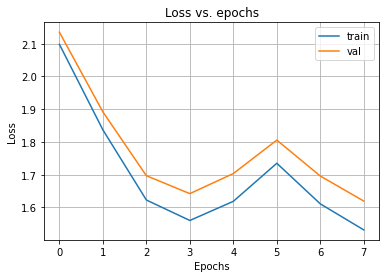

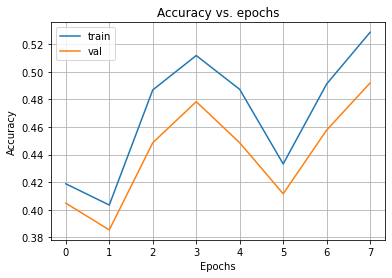

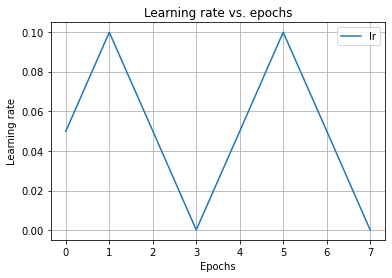

In [213]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 8
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 900
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)
plot_lr(history)

In [214]:
objective = AccuracyMetrics()
build_model = build_model_func
n = 100
n_epochs = 8
batch_size = 100

params = {"reg_rate_l2": sample_hyper_param(n=n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 77.83it/s]
epoch 1/8 
 	 -- train loss = 1.52400142557297, train accuracy = 0.4716666666666667 
	 -- val loss = 1.5809540144570298, val accuracy = 0.4414 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 74.72it/s]
epoch 2/8 
 	 -- train loss = 1.479128759319482, train accuracy = 0.48204444444444444 
	 -- val loss = 1.5739663410607219, val accuracy = 0.4456 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 76.36it/s]
epoch 3/8 
 	 -- train loss = 1.4222555429948258, train accuracy = 0.5036666666666667 
	 -- val loss = 1.5482117858541584, val accuracy

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.01it/s]
epoch 7/8 
 	 -- train loss = 1.2974829107943062, train accuracy = 0.5577555555555556 
	 -- val loss = 1.4867152458286925, val accuracy = 0.4936 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.59it/s]
epoch 8/8 
 	 -- train loss = 1.2588618460954273, train accuracy = 0.5750444444444445 
	 -- val loss = 1.4654016726449284, val accuracy = 0.5026 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 81.36it/s]
epoch 1/8 
 	 -- train loss = 1.8865329537303048, train accuracy = 0.4321333333333333 
	 -- val loss = 1.9139475867561293, val accuracy = 0.4164 


startin

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.71it/s]
epoch 5/8 
 	 -- train loss = 1.601659635544884, train accuracy = 0.4809777777777778 
	 -- val loss = 1.7129992901639195, val accuracy = 0.444 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.35it/s]
epoch 6/8 
 	 -- train loss = 1.5280310895214821, train accuracy = 0.5067333333333334 
	 -- val loss = 1.6449536451518276, val accuracy = 0.4594 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.43it/s]
epoch 7/8 
 	 -- train loss = 1.4742945695549214, train accuracy = 0.5324 
	 -- val loss = 1.5975229365906158, val accuracy = 0.4814 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.42it/s]
epoch 8/8 
 	 -- train loss = 1.4404750300313816, train accuracy = 0.5475777777777778 
	 -- val loss = 1.571012735191273, val accuracy = 0.4942 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: 

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.21it/s]
epoch 3/8 
 	 -- train loss = 1.6317743977902117, train accuracy = 0.4794 
	 -- val loss = 1.7168765796294387, val accuracy = 0.4466 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.67it/s]
epoch 4/8 
 	 -- train loss = 1.6919580678262869, train accuracy = 0.44855555555555554 
	 -- val loss = 1.7741225632098574, val accuracy = 0.423 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.63it/s]
epoch 5/8 
 	 -- train loss = 1.6554024507691727, train accuracy = 0.4636222222222222 
	 -- val loss = 1.746225650336837, val accuracy = 0.4324 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.36it/s]
epoch 6/8 
 	 -- train loss = 1.5805422910728129, train accuracy = 0.49722222222222223 
	 -- val loss = 1.669112609606574, val accuracy = 0.4616 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.82it/s]
epoch 7/

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.40it/s]
epoch 1/8 
 	 -- train loss = 1.6910862459300464, train accuracy = 0.4684888888888889 
	 -- val loss = 1.743401379679134, val accuracy = 0.4414 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.16it/s]
epoch 2/8 
 	 -- train loss = 1.6333191329978498, train accuracy = 0.47344444444444445 
	 -- val loss = 1.7189221731852475, val accuracy = 0.4436 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.36it/s]
epoch 3/8 
 	 -- train loss = 1.5637824495753496, train accuracy = 0.49704444444444446 
	 -- val loss = 1.6742748415951443, val accuracy = 0.4586 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.32it/s]
epoch 4/8 
 	 -- train loss = 1.6216797708723685, train accuracy = 0.46844444444444444 
	 -- val loss = 1.737191023261651, val accuracy = 0.4308 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 81.61

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.12it/s]
epoch 8/8 
 	 -- train loss = 1.2188583755858216, train accuracy = 0.5756666666666667 
	 -- val loss = 1.4468291365556252, val accuracy = 0.4968 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.50it/s]
epoch 1/8 
 	 -- train loss = 1.523534018587236, train accuracy = 0.4717777777777778 
	 -- val loss = 1.5857827578179342, val accuracy = 0.4406 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.18it/s]
epoch 2/8 
 	 -- train loss = 1.4787964757841483, train accuracy = 0.48006666666666664 
	 -- val loss = 1.5756593119265947, val accuracy = 0.4474 


startin

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.65it/s]
epoch 6/8 
 	 -- train loss = 1.3273343355018419, train accuracy = 0.5335333333333333 
	 -- val loss = 1.5172620248030069, val accuracy = 0.4666 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.70it/s]
epoch 7/8 
 	 -- train loss = 1.2651481961692976, train accuracy = 0.5577777777777778 
	 -- val loss = 1.4722031788783054, val accuracy = 0.4808 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.60it/s]
epoch 8/8 
 	 -- train loss = 1.2182848373133937, train accuracy = 0.5759555555555556 
	 -- val loss = 1.4550394743290753, val accuracy = 0.4898 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


startin

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.54it/s]
epoch 4/8 
 	 -- train loss = 1.512762341854923, train accuracy = 0.48002222222222224 
	 -- val loss = 1.6516056475088787, val accuracy = 0.4346 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.44it/s]
epoch 5/8 
 	 -- train loss = 1.4708126440605744, train accuracy = 0.4926888888888889 
	 -- val loss = 1.6222027296303982, val accuracy = 0.4472 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.22it/s]
epoch 6/8 
 	 -- train loss = 1.3727988916452427, train accuracy = 0.5300444444444444 
	 -- val loss = 1.5412901535933838, val accuracy = 0.4704 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 81.85it/s]
epoch 7/8 
 	 -- train loss = 1.3018998395557742, train accuracy = 0.5595555555555556 
	 -- val loss = 1.4886083054252066, val accuracy = 0.4866 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.78i

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.18it/s]
epoch 2/8 
 	 -- train loss = 1.7198709916250114, train accuracy = 0.4616222222222222 
	 -- val loss = 1.782624102375521, val accuracy = 0.4354 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.84it/s]
epoch 3/8 
 	 -- train loss = 1.647462432257831, train accuracy = 0.47302222222222223 
	 -- val loss = 1.721855451429825, val accuracy = 0.4392 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.28it/s]
epoch 4/8 
 	 -- train loss = 1.6980188982500917, train accuracy = 0.4478888888888889 
	 -- val loss = 1.7738336570551965, val accuracy = 0.4256 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 75.04it/s]
epoch 5/8 
 	 -- train loss = 1.678253030075922, train accuracy = 0.4582222222222222 
	 -- val loss = 1.7581184542988564, val accuracy = 0.4276 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.53it/s

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.77it/s]
epoch 1/8 
 	 -- train loss = 1.5558228728307866, train accuracy = 0.47171111111111114 
	 -- val loss = 1.6127308532443192, val accuracy = 0.4476 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.94it/s]
epoch 2/8 
 	 -- train loss = 1.515541856396308, train accuracy = 0.4801111111111111 
	 -- val loss = 1.6062858479347288, val accuracy = 0.4466 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 75.71it/s]
epoch 3/8 
 	 -- train loss = 1.4662673260236638, train accuracy = 0.4960222222222222 
	 -- val loss = 1.5942945917666576, val accuracy = 0.4518 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 72.21it/s]
epoch 4/8 
 	 -- train loss = 1.5585087916174303, train accuracy = 0.46613333333333334 
	 -- val loss = 1.7053406410215548, val accuracy = 0.4314 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 73.97

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.66it/s]
epoch 8/8 
 	 -- train loss = 1.2167435697148572, train accuracy = 0.5770666666666666 
	 -- val loss = 1.4426664537231144, val accuracy = 0.4924 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.75it/s]
epoch 1/8 
 	 -- train loss = 1.6131872152198619, train accuracy = 0.4680888888888889 
	 -- val loss = 1.6704555268491954, val accuracy = 0.4366 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.53it/s]
epoch 2/8 
 	 -- train loss = 1.5667277571569542, train accuracy = 0.47735555555555553 
	 -- val loss = 1.657014845096486, val accuracy = 0.443 


starting

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.49it/s]
epoch 6/8 
 	 -- train loss = 1.3392246390026774, train accuracy = 0.5348888888888889 
	 -- val loss = 1.5155501271182368, val accuracy = 0.4732 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.89it/s]
epoch 7/8 
 	 -- train loss = 1.2683078132568595, train accuracy = 0.5614222222222223 
	 -- val loss = 1.4715751291339305, val accuracy = 0.4916 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.50it/s]
epoch 8/8 
 	 -- train loss = 1.2260381100595215, train accuracy = 0.5775555555555556 
	 -- val loss = 1.45326400303306, val accuracy = 0.4936 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting 

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.34it/s]
epoch 4/8 
 	 -- train loss = 1.481549176907191, train accuracy = 0.4756 
	 -- val loss = 1.6349671195754731, val accuracy = 0.4302 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.09it/s]
epoch 5/8 
 	 -- train loss = 1.4261103606015728, train accuracy = 0.49691111111111114 
	 -- val loss = 1.5898332371049737, val accuracy = 0.4458 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.44it/s]
epoch 6/8 
 	 -- train loss = 1.3270091428979245, train accuracy = 0.5324888888888889 
	 -- val loss = 1.501860881385782, val accuracy = 0.4692 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 82.63it/s]
epoch 7/8 
 	 -- train loss = 1.2573423626980904, train accuracy = 0.5600444444444445 
	 -- val loss = 1.4588007420644629, val accuracy = 0.4874 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.56it/s]
epoch 8/

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.90it/s]
epoch 2/8 
 	 -- train loss = 1.4776637234348753, train accuracy = 0.4785333333333333 
	 -- val loss = 1.5729974304275551, val accuracy = 0.4478 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.03it/s]
epoch 3/8 
 	 -- train loss = 1.4188050267959955, train accuracy = 0.5034222222222222 
	 -- val loss = 1.541515598273623, val accuracy = 0.462 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.23it/s]
epoch 4/8 
 	 -- train loss = 1.4796048330306077, train accuracy = 0.47906666666666664 
	 -- val loss = 1.623306507265193, val accuracy = 0.4376 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.71it/s]
epoch 5/8 
 	 -- train loss = 1.4328842923963576, train accuracy = 0.49793333333333334 
	 -- val loss = 1.5879660460637466, val accuracy = 0.4528 


starting epoch: 6 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.54it

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.85it/s]
epoch 1/8 
 	 -- train loss = 1.6154576602308046, train accuracy = 0.46924444444444446 
	 -- val loss = 1.6723480386901883, val accuracy = 0.4446 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.62it/s]
epoch 2/8 
 	 -- train loss = 1.5723202350898415, train accuracy = 0.47986666666666666 
	 -- val loss = 1.6617737139218252, val accuracy = 0.4454 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.41it/s]
epoch 3/8 
 	 -- train loss = 1.5168011834082216, train accuracy = 0.4957111111111111 
	 -- val loss = 1.639253902976198, val accuracy = 0.4532 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 81.46it/s]
epoch 4/8 
 	 -- train loss = 1.5787186577645345, train accuracy = 0.47173333333333334 
	 -- val loss = 1.7038288459739508, val accuracy = 0.4354 


starting epoch: 5 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.2

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.01it/s]
epoch 8/8 
 	 -- train loss = 1.2607632997591591, train accuracy = 0.5754 
	 -- val loss = 1.4666318193754813, val accuracy = 0.5016 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.52it/s]
epoch 1/8 
 	 -- train loss = 1.768356175231658, train accuracy = 0.4678888888888889 
	 -- val loss = 1.8179162395538628, val accuracy = 0.4428 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 84.65it/s]
epoch 2/8 
 	 -- train loss = 1.6800991064939186, train accuracy = 0.47017777777777775 
	 -- val loss = 1.7567591060647076, val accuracy = 0.4388 


starting epoch: 3 .

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.20it/s]
epoch 6/8 
 	 -- train loss = 1.336355225497438, train accuracy = 0.5337111111111111 
	 -- val loss = 1.5091734555034357, val accuracy = 0.4716 


starting epoch: 7 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.10it/s]
epoch 7/8 
 	 -- train loss = 1.2679362542999022, train accuracy = 0.5605555555555556 
	 -- val loss = 1.4656195014271562, val accuracy = 0.49 


starting epoch: 8 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 83.49it/s]
epoch 8/8 
 	 -- train loss = 1.2245532389128233, train accuracy = 0.5762888888888889 
	 -- val loss = 1.4471405268076134, val accuracy = 0.5006 


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.018042195912175808^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.0 x N(0.0, 0.1414213562373095^2), reg: l2
	 b -- init: Xavier ~ 1.0 x N(0.0, 1.0^2)
	 activation: softmax


starting e

KeyboardInterrupt: 